In [4]:
from pathlib import Path

# Make the path object:
cache_path = Path('/tmp/cache')

# Just because we have made a cache path object doesn't mean that the directory
# we made exists; here we check if it exists and make the directory if not.
if not cache_path.exists():
    cache_path.mkdir()


In [5]:
from utilities import ls, crawl
import nibabel as nib

In [6]:
from cloudpathlib import S3Path, S3Client

client = S3Client(
    local_cache_dir=cache_path,
    no_sign_request=True)

hbn_base_path = S3Path(
    "s3://fcp-indi/",
    client=client)

In [7]:
base_path = Path('/home/jovyan/shared')
bids_path = hbn_base_path / "data" / "Projects" / "HBN" / "BIDS_curated" 
sub_code = ["sub-NDARAA948VFH", "sub-NDARAB055BPR"]

qsi_path = base_path / 'diffusion_group_data' / 'results' / 'derivatives' / 'qsiprep'
print(qsi_path.exists())

True


In [92]:
# # Quickly look if BIDSified
# print(bids_path)
# for sub in sub_code: 
#     sub_path = bids_path / f'{sub}'
#     crawl(sub_path)

In [8]:
# Choose on sub to test
sub_code = ['sub-NDARAA948VFH', 'sub-NDARAB055BPR']
bids_sub_idx = 0 
bids_sub     = f'{sub_code[bids_sub_idx]}'
bids_sub


'sub-NDARAA948VFH'

In [9]:
# Set variables on your file names
bids_ses   = 'HBNsiteRU'
bids_acq_anat= 'HCP'
bids_acq   = '64dir'
bids_space = 'T1w'
bids_desc  = 'preproc'


In [10]:
# Set & load DWI file names
from dipy.io.image import load_nifti, save_nifti
t1_fname = bids_path / bids_sub / f'ses-{bids_ses}' /'anat' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_anat}_T1w.nii.gz'
t1_data, t1_affine, t1_nii    = load_nifti(t1_fname, return_img=True)

# load raw DWI file names
dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.nii.gz'
bval_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.bval'
bvec_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_dwi.bvec'
# type(dwi_fname)

# Load QSIprep outputs
dwi_fname_qsi  = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.nii.gz'
bval_fname_qsi = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.bval'
bvec_fname_qsi = qsi_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq}_space-{bids_space}_desc-{bids_desc}_dwi.bvec'

# Load volumes
from dipy.io.image import load_nifti, save_nifti
dwi_data, dwi_affine, dwi_nii = load_nifti(dwi_fname, return_img=True)
dwi_nii     = nib.load(dwi_fname)
dwi_data    = dwi_nii.get_fdata()
dwi_hdr     = dwi_nii.header

dwi_data_qsi, dwi_affine, dwi_nii = load_nifti(dwi_fname_qsi, return_img=True)
dwi_nii_qsi     = nib.load(dwi_fname_qsi)
dwi_data_qsi    = dwi_nii.get_fdata()
dwi_hdr_qsi     = dwi_nii.header
print('Volume loaded')

Volume loaded


In [80]:
# # returns dwi data size &  dimensions of each voxel
# print('DWI shape:')
# print(dwi_nii.shape)
# print('voxel dimensions:')
# print(dwi_nii.header.get_zooms()[:3])

In [11]:
# get bvals and bvecs in a diffusion gradient table
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

# get bvals and bvecs in a diffusion gradient table
bvals, bvecs = read_bvals_bvecs(bval_fname.fspath, bvec_fname.fspath)
print('Load gradient table')   
gtab = gradient_table(bvals, bvecs)

# Take  aquick look at the gradient table info & bvals
print('Gradients table info')
print(gtab.info)

# get bvals and bvecs in a diffusion gradient table
bvals_qsi, bvecs_qsi = read_bvals_bvecs(bval_fname_qsi.as_posix(), bvec_fname_qsi.as_posix())
print('Load gradient table')   
gtab_qsi = gradient_table(bvals, bvecs)

# Take  aquick look at the gradient table & bvals
print('Gradients table info')
print(gtab_qsi.info)

# # Show gradient table info & bvals
# print('B-values')
# print(gtab.bvals)
# print('B-vectors')
# print(gtab.bvecs[:10, :])

Load gradient table
Gradients table info
B-values shape (129,)
         min 0.000000
         max 2000.000000
B-vectors shape (129, 3)
          min -0.996103
          max 0.999997

None
Load gradient table
Gradients table info
B-values shape (129,)
         min 0.000000
         max 2000.000000
B-vectors shape (129, 3)
          min -0.996103
          max 0.999997

None


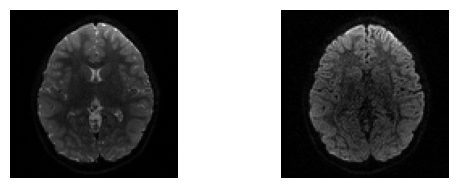

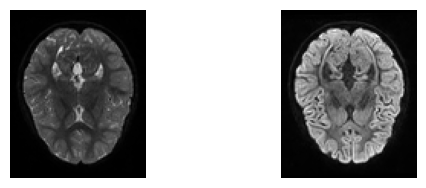

In [12]:
# quickly visualize the results
import matplotlib.pyplot as plt

sli = dwi_data.shape[2] // 2
plt.figure('Showing the datasets')
# plt.subplot(1, 3, 1).set_axis_off()                                  # plot volume in the left
# plt.imshow(t1_data[:, :, 150].T, cmap ='gray', origin='lower')       # plot T1w sag view, slice 85 -roughly middline
plt.subplot(2, 2, 1).set_axis_off()     # plot volume in the middle
plt.imshow(dwi_data[:, :, sli, 0].T, cmap='gray', origin='lower')    # plot dMRI in axial view, slice 35 of volume 0 (b0)
plt.subplot(2, 2, 2).set_axis_off()     # plot volume in the right
plt.imshow(dwi_data[:, :, sli, 25].T, cmap='gray', origin='lower')   # plot dMRI in axial view, slice 35 of volume 24
plt.show()

sli_qsi = dwi_data_qsi.shape[2] // 2
plt.figure('Showing the datasets')
# plt.subplot(1, 3, 1).set_axis_off()                                  # plot volume in the left
# plt.imshow(t1_data[:, :, 150].T, cmap ='gray', origin='lower')       # plot T1w sag view, slice 85 -roughly middline
plt.subplot(2, 2, 3).set_axis_off()     # plot volume in the middle
plt.imshow(dwi_data_qsi[:, :, sli_qsi, 0].T, cmap='gray', origin='lower')    # plot dMRI in axial view, slice 35 of volume 0 (b0)
plt.subplot(2, 2, 4).set_axis_off()     # plot volume in the right
plt.imshow(dwi_data_qsi[:, :, sli_qsi, 25].T, cmap='gray', origin='lower')   # plot dMRI in axial view, slice 35 of volume 24
plt.show()

In [18]:
#  Create the dwi masks
from dipy.segment.mask import median_otsu, multi_median

print('Getting dwi mask')
# Generates brian mask
dwi_data_masked, dwi_mask = median_otsu(dwi_data, vol_idx=range(10, 50),
                                        median_radius=5, numpass=2,
                                        autocrop=False, dilate=2)

print('Getting dwi mask QSI prep')
dwi_data_masked_qsi, dwi_mask_qsi = median_otsu(dwi_data_qsi, vol_idx=range(10, 50),
                                        median_radius=3, numpass=2,
                                        autocrop=False, dilate=2)


Getting dwi mask
Getting dwi mask QSI prep


In [16]:
print(dwi_data_masked.shape)

(104, 104, 72, 129)


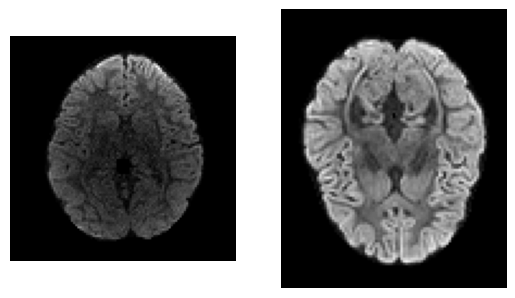

In [19]:
# quickly visualize the results to evaluate whether to adjust mask params (?)
sli     = dwi_data_masked.shape[2] // 2
sli_qsi = dwi_data_masked_qsi.shape[2] // 2

plt.figure('Simple vs QSI')
plt.subplot(1, 2, 1).set_axis_off()     # plot volume in the middle
plt.imshow(dwi_data_masked[:, :, sli, 25].T, cmap='gray', origin='lower')    # plot dMRI in axial view, slice 35 of volume 0 (b0)
plt.subplot(1, 2, 2).set_axis_off()     # plot volume in the right
plt.imshow(dwi_data_masked_qsi[:, :, sli_qsi, 25].T, cmap='gray', origin='lower')   # plot dMRI in axial view, slice 35 of volume 24
plt.show()

In [20]:
# Denoise# 
from dipy.denoise.patch2self import patch2self
print('Denoising')
dwi_data_den = patch2self(dwi_data_masked, bvals, model='ols', verbose=True,
                          shift_intensity=True,
                          clip_negative_vals=False,
                          b0_threshold=50)

# Now plot before and after to see the denoising
gra  = 24  # pick out a random volume for a particular gradient direction
orig = dwi_data_masked[:, :, sli, gra]
den  = dwi_data_den[:, :, sli, gra]


Denoising
b0 denoising skipped...
Denoised DWI Volume:  0
Denoised DWI Volume:  1
Denoised DWI Volume:  2
Denoised DWI Volume:  3
Denoised DWI Volume:  4
Denoised DWI Volume:  5
Denoised DWI Volume:  6
Denoised DWI Volume:  7
Denoised DWI Volume:  8
Denoised DWI Volume:  9
Denoised DWI Volume:  10
Denoised DWI Volume:  11
Denoised DWI Volume:  12
Denoised DWI Volume:  13
Denoised DWI Volume:  14
Denoised DWI Volume:  15
Denoised DWI Volume:  16
Denoised DWI Volume:  17
Denoised DWI Volume:  18
Denoised DWI Volume:  19
Denoised DWI Volume:  20
Denoised DWI Volume:  21
Denoised DWI Volume:  22
Denoised DWI Volume:  23
Denoised DWI Volume:  24
Denoised DWI Volume:  25
Denoised DWI Volume:  26
Denoised DWI Volume:  27
Denoised DWI Volume:  28
Denoised DWI Volume:  29
Denoised DWI Volume:  30
Denoised DWI Volume:  31
Denoised DWI Volume:  32
Denoised DWI Volume:  33
Denoised DWI Volume:  34
Denoised DWI Volume:  35
Denoised DWI Volume:  36
Denoised DWI Volume:  37
Denoised DWI Volume:  38
D

Text(0.5, 1.0, 'Residuals')

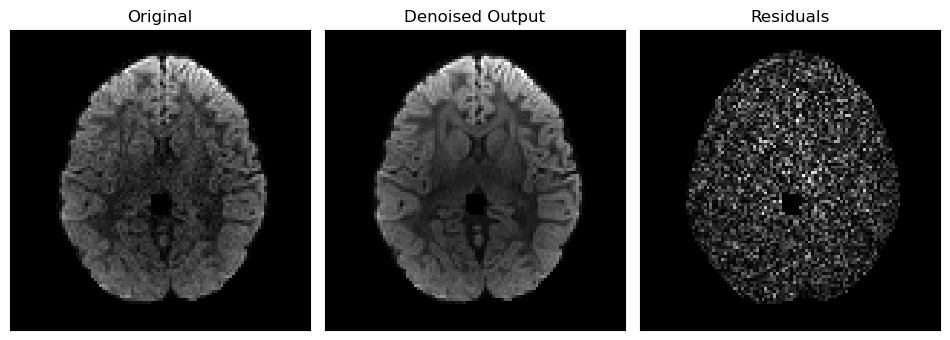

In [21]:
import numpy as np
# prepare to plot
fig1, ax = plt.subplots(1, 3, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)

# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)
# plot original, denoised, and residuals
ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none', origin='lower')
ax.flat[0].set_title('Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none', origin='lower')
ax.flat[2].set_title('Residuals')

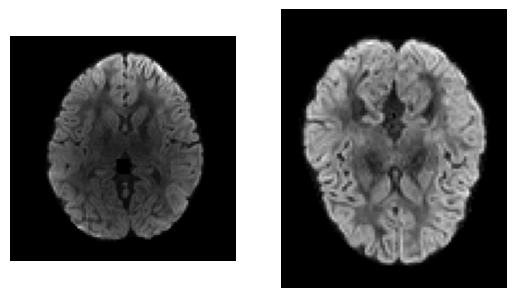

In [22]:
# Now compare Simple vs QSI preproc

plt.figure('Simple vs QSI')
plt.subplot(1, 2, 1).set_axis_off()     # plot volume in the middle
plt.imshow(dwi_data_den[:, :, sli, 5].T, cmap='gray', origin='lower')            # plot dMRI in axial view, slice 35 of volume 0 (b0)
plt.subplot(1, 2, 2).set_axis_off()     # plot volume in the right
plt.imshow(dwi_data_masked_qsi[:, :, sli_qsi, 5].T, cmap='gray', origin='lower') # plot dMRI in axial view, slice 35 of volume 24
plt.show()

In [23]:
# Fitting tensor model
from dipy.io.utils    import nifti1_symmat
from dipy.reconst.dti import (TensorModel, color_fa, fractional_anisotropy,
                              lower_triangular, geodesic_anisotropy,
                              mean_diffusivity, axial_diffusivity,
                              radial_diffusivity, lower_triangular)
from dipy.segment.tissue import TissueClassifierHMRF

print('Fitting tensor model on simple preproc')
ten_model= TensorModel(gtab)
tenfit   = ten_model.fit(dwi_data_den)
print('Fitting tensor model on QSI prep')
ten_model= TensorModel(gtab_qsi)
tenfit_qsi   = ten_model.fit(dwi_data_masked_qsi)


Fitting tensor model on simple preproc
Fitting tensor model on QSI prep


In [24]:
# Generate WM mask w/ FA thresholding
import numpy as np

FA      = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0
FA      = np.clip(FA, 0, 1)
tensor_vals = lower_triangular(tenfit.quadratic_form)   # recover the covariance matrix
ten_nii = nifti1_symmat(tensor_vals, affine=dwi_affine)     # Get a nii with a symmetric matrix intent

FA_qsi      = fractional_anisotropy(tenfit_qsi.evals)
FA_qsi[np.isnan(FA_qsi)] = 0
FA_qsi      = np.clip(FA_qsi, 0, 1)
tensor_vals_qsi = lower_triangular(tenfit_qsi.quadratic_form)   # recover the covariance matrix
ten_nii_qsi     = nifti1_symmat(tensor_vals_qsi, affine=dwi_affine) # Get a nii with a symmetric matrix intent

# potentially test to improve WM mask?
# wm_mask = (np.logical_or(FA >= 0.4, (np.logical_and(FA >= 0.15, MD >= 0.0011))))

wm_FA     = FA > 0.12
wm_FA_qsi = FA_qsi > 0.12

In [26]:
# Estimate fiber orientations at the voxel level
from dipy.direction.peaks import peaks_from_model
from dipy.reconst import csdeconv, shm, dti

dti_model = dti.TensorModel(gtab)
# run constrained spherical deconvolution model
response, ratio = csdeconv.auto_response_ssst(gtab, dwi_data_den, roi_radii=10, fa_thr=0.7)
csd_model       = csdeconv.ConstrainedSphericalDeconvModel(gtab, response)
# csd_fit         = csd_model.fit(dwi_data_masked, mask=wm_FA)

dti_model_qsi = dti.TensorModel(gtab_qsi)
# run constrained spherical deconvolution model
response, ratio = csdeconv.auto_response_ssst(gtab_qsi, dwi_data_masked_qsi, roi_radii=10, fa_thr=0.7)
csd_model_qsi   = csdeconv.ConstrainedSphericalDeconvModel(gtab_qsi, response)
# csd_fit         = csd_model.fit(dwi_data_masked, mask=wm_FA_qsi)

Text(0.5, 1.0, 'CSO voxel (?)')

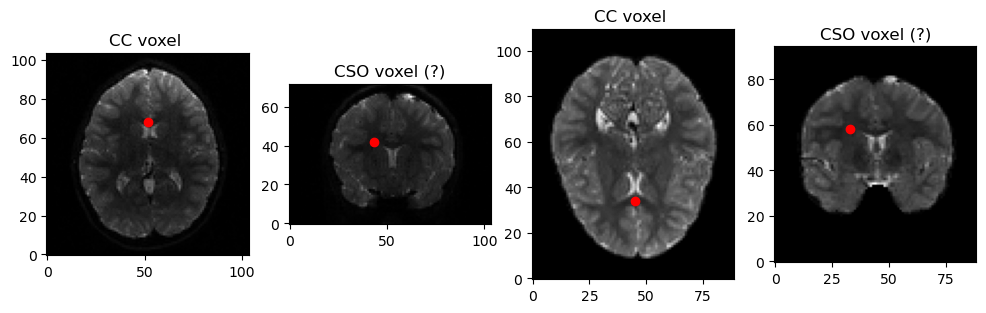

In [37]:
# print(dwi_data_masked.shape)
# cc_vox      = dwi_data[52, 68, 38]
# cso_vox     = dwi_data[42, 65, 40]
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow((dwi_data[:, :, 38, 0].astype('float')).T, cmap='gray', origin='lower')
ax[0].scatter(52, 68, c='r')
ax[0].set_title('CC voxel ')
# 43,65,42
ax[1].imshow((dwi_data[:, 65, :, 0].astype('float')).T, cmap='gray', origin='lower')
ax[1].scatter(43, 42, c='r')
ax[1].set_title('CSO voxel (?)')

ax[2].imshow((dwi_data_masked_qsi[:, :, 49, 0].astype('float')).T, cmap='gray', origin='lower')
ax[2].scatter(45, 34, c='r')
ax[2].set_title('CC voxel ')
# 33 46 57
ax[3].imshow((dwi_data_masked_qsi[:, 46, :, 0].astype('float')).T, cmap='gray', origin='lower')
ax[3].scatter(33, 58, c='r')
ax[3].set_title('CSO voxel (?)')

In [44]:
# Setting voxels to test recon models
cc_vox      = dwi_data[52, 68, 38]
cso_vox     = dwi_data[43, 65, 42]

cc_vox_qsi  = dwi_data_masked_qsi[45, 34, 49]
cso_vox_qsi = dwi_data_masked_qsi[33, 46, 58]

# Compute 8-fold cross-validation for
# First for corpus callosum
# Simple preproc
import dipy.reconst.cross_validation as xval
dti_cc    = xval.kfold_xval(dti_model, cc_vox, 8)
csd_cc    = xval.kfold_xval(csd_model, cc_vox, 8, response)
# QSI preproc
import dipy.reconst.cross_validation as xval
dti_cc_qsi= xval.kfold_xval(dti_model_qsi, cc_vox_qsi, 8)
csd_cc_qsi= xval.kfold_xval(csd_model_qsi, cc_vox_qsi, 8, response)

# # Now for centrum semiovale
# # Simple preproc:
dti_cso   = xval.kfold_xval(dti_model, cso_vox, 8)
csd_cso   = xval.kfold_xval(csd_model, cso_vox, 8, response)
# # QSI preproc:
dti_cso_qsi  = xval.kfold_xval(dti_model_qsi, cso_vox_qsi, 8)
csd_cso_qsi  = xval.kfold_xval(csd_model_qsi, cso_vox_qsi, 8, response)

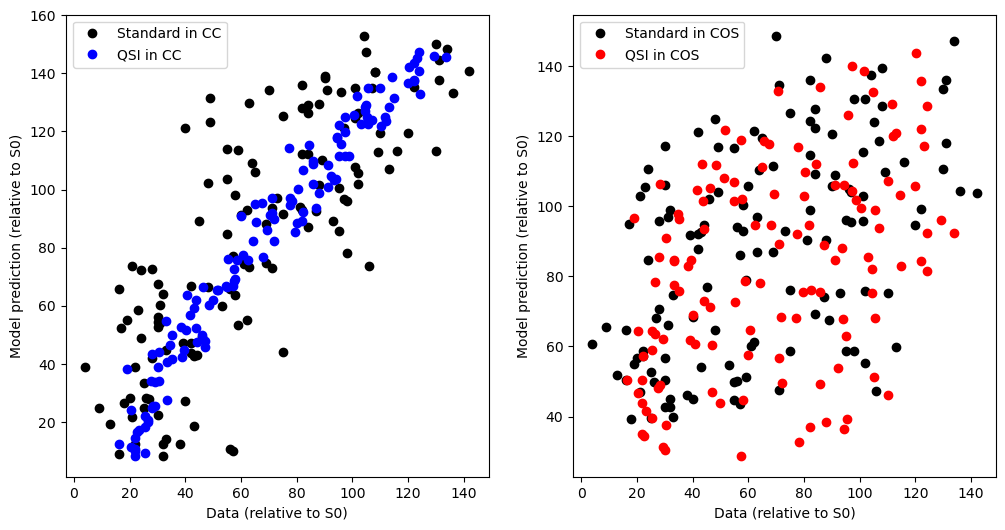

In [46]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches([12, 6])
ax[0].plot(cc_vox[gtab.b0s_mask == 0], dti_cc[gtab.b0s_mask == 0], 'o',
           color='k', label='Standard in CC')
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='QSI in CC')
ax[1].plot(cc_vox[gtab.b0s_mask == 0], dti_cso[gtab.b0s_mask == 0], 'o',
           color='k', label='Standard in COS')
ax[1].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='QSI in COS')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

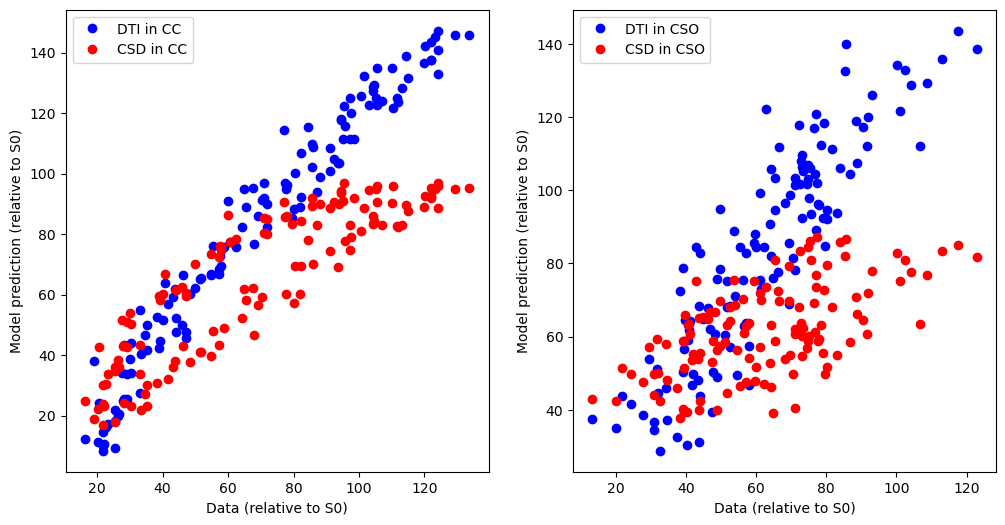

In [47]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches([12, 6])
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='DTI in CC')
ax[0].plot(cc_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cc_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='CSD in CC')
ax[1].plot(cso_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='b', label='DTI in CSO')
ax[1].plot(cso_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cso_qsi[gtab_qsi.b0s_mask == 0], 'o',
           color='r', label='CSD in CSO')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

In [49]:
# Now let's compute the coefficent of determination
import scipy.stats as stats

cc_dti_r2  = stats.pearsonr(cc_vox[gtab.b0s_mask == 0], dti_cc[gtab.b0s_mask == 0])[0]**2
cc_csd_r2  = stats.pearsonr(cc_vox[gtab.b0s_mask == 0], csd_cc[gtab.b0s_mask == 0])[0]**2
cso_dti_r2 = stats.pearsonr(cso_vox[gtab.b0s_mask == 0], dti_cso[gtab.b0s_mask == 0])[0]**2
cso_csd_r2 = stats.pearsonr(cso_vox[gtab.b0s_mask == 0], csd_cso[gtab.b0s_mask == 0])[0]**2

cc_dti_r2_qsi  = stats.pearsonr(cc_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cc_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cc_csd_r2_qsi  = stats.pearsonr(cc_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cc_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cso_dti_r2_qsi = stats.pearsonr(cso_vox_qsi[gtab_qsi.b0s_mask == 0], dti_cso_qsi[gtab_qsi.b0s_mask == 0])[0]**2
cso_csd_r2_qsi = stats.pearsonr(cso_vox_qsi[gtab_qsi.b0s_mask == 0], csd_cso_qsi[gtab_qsi.b0s_mask == 0])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2, cc_csd_r2, cso_dti_r2, cso_csd_r2))

print("QSI Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "QSI Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2_qsi, cc_csd_r2_qsi, cso_dti_r2_qsi, cso_csd_r2_qsi))

Corpus callosum
DTI R2 : 0.6302626291216452
CSD R2 : 0.5395945083615823

Centrum Semiovale
DTI R2 : 0.5285638712347458
CSD R2 : 0.15018244436013653

QSI Corpus callosum
DTI R2 : 0.9560279459650302
CSD R2 : 0.7781133200336086

QSI Centrum Semiovale
DTI R2 : 0.7922644593489386
CSD R2 : 0.3526544432371334



In [38]:
# dig into plotting tensor at the voxel level
from dipy.viz import window, actor
from dipy.sims.voxel import single_tensor_odf

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T


response_odf = single_tensor_odf(default_sphere.vertices, evals, evecs)
# transform our data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(response_odf, sphere=default_sphere,
                                  colormap='plasma')
scene.add(response_actor)
# print('Saving illustration as csd_response.png')
# window.record(scene, out_path='csd_response.png', size=(200, 200))
# if interactive:
#     window.show(scene)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dipy/viz/__init__.py:22: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(


ImportError: cannot import name 'window' from 'dipy.viz' (/srv/conda/envs/notebook/lib/python3.10/site-packages/dipy/viz/__init__.py)

In [37]:
# TO DO | Implement probabilistic tractography of single bundle
# from dipy.direction import ProbabilisticDirectionGetter
# from dipy.data import small_sphere
# from dipy.io.stateful_tractogram import Space, StatefulTractogram
# from dipy.io.streamline import save_trk
# from dipy.tracking.local_tracking import LocalTracking
# from dipy.tracking.streamline import Streamlines
# from dipy.viz import window, actor, colormap, has_fury

# seed_mask = (???)  # Find a mask with the tract to plot and use as seeds
# seeds = utils.seeds_from_mask(seed_mask, affine, density=1)
# fod = csd_fit.odf(small_sphere)
# pmf = fod.clip(min=0)
# prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30.,
#                                                 sphere=small_sphere)
# streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
#                                      affine, step_size=.5)
# streamlines = Streamlines(streamline_generator)
# sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
# save_trk(sft, "tractogram_probabilistic_dg_pmf.trk")

# if has_fury:
#     scene = window.Scene()
#     scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
#     window.record(scene, out_path='tractogram_probabilistic_dg_pmf.png',
#                   size=(800, 800))
#     if interactive:
#         window.show(scene)

In [ ]:
# # From the spherical harmonic model, run Q-Ball imaging with Solid Angle Consideration
# from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

# csa_model = shm.CsaOdfModel(gtab, 4) # Implement Constant Solid Angle ODF Model | Maximal spherical harmonic order=6
# gfa_csd_fit   = csa_model.fit(dwi_data_masked, mask = white_matter).gfa
# # print('gfa_csd.shape (%d, %d, %d)' % gfa_csd.shape)
# # stopping_criterion = ThresholdStoppingCriterion(gfa_csd, .25)

# # We can also calculate ODFs (Orientation Distribution Function) using peaks_from_model
# # GFA which is similar to FA but for ODF based models.
# csa_peaks = peaks.peaks_from_model(csa_model, dwi_data_masked, peaks.default_sphere,
#                              relative_peak_threshold=.5,
#                              min_separation_angle=25,
#                              mask=white_matter,
#                              return_odf=False,
#                              normalize_peaks=True)
# # gfa_peaks = csa_peaks.gfa
# # stopping_criterion_peaks = ThresholdStoppingCriterion(gfa_peaks, .25)
# # print('gfa_peaks.shape (%d, %d, %d)' % gfa_peaks.shape)